Nome: Felipe Faustino Brito

Matrícula: 2021007366

In [1]:
from scipy import signal
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

### Gerar um sinal amostrado com 10kHz com os seguintes comandos no Python:

In [85]:
import numpy as np
Ts = 1 / 10000
Fs = 1 / Ts
t = np.arange(0,0.2,Ts)
s = 2*np.cos(2*np.pi*400*t) + 0.5*np.cos(2*np.pi*1000*t) + 1.5*np.cos(2*np.pi*1500*t) + np.cos(2*np.pi*1800*t)

In [86]:
def plot_signal(signal: np.ndarray, time: np.ndarray, frequency: float, limite=800):
    """
        Plota um sinal no domínio do tempo e sua resposta em frequência.
        
        Params:
            signal (np.ndarray): O sinal a ser plotado.
            time (np.ndarray): O array de tempos correspondente ao sinal.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            limite (float, opcional): O limite superior do eixo x da resposta em frequência.
    """
    # Plotar o sinal no domínio do tempo
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title('Sinal')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Resposta em frequência (FFT)
    frequencia_fft = np.fft.fftfreq(len(signal), 1/frequency)
    espectro_fft = np.fft.fft(signal)

    # Plotar a magnitude da resposta em frequência
    plt.figure(figsize=(10, 4))
    plt.plot(frequencia_fft[:len(frequencia_fft)//2], np.abs(espectro_fft)[:len(espectro_fft)//2])
    plt.title('Resposta em frequência do sinal')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.xlim(0, limite)
    plt.show()

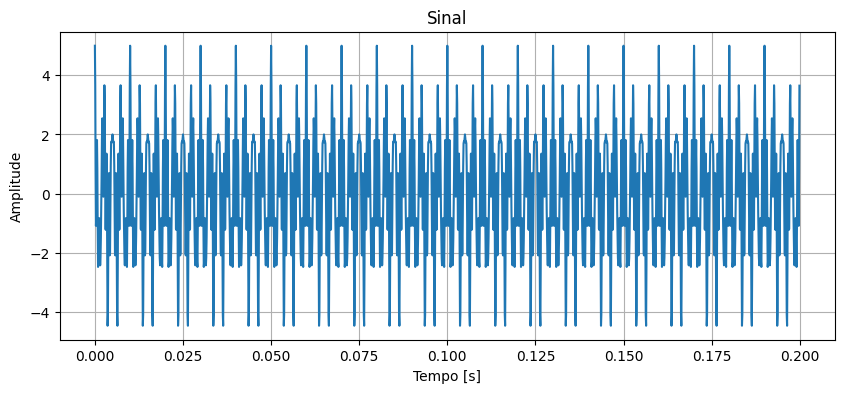

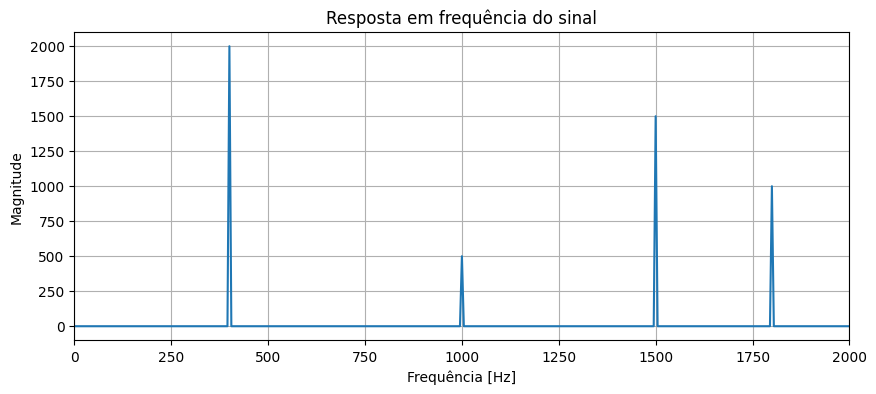

In [87]:
plot_signal(s, t, 1/Ts, limite=2000)

### 1) Construir um filtro Windowed-sinc (sem ripple na banda de passagem) para reduzir a amplitude das componentes de 1000Hz e de 1500Hz para menos de 1% de suas amplitudes originais. É desejável que o filtro não afete a amplitude da componente que deve permanecer no sinal (tolerância de 1%). Utilizar o método apresentado na aula para gerar o kernel. Forneça:

In [88]:
def inversao_espectral(h):
# faz a inversão espectral
    kernel_PA = -h
    indice_centro = int (len(h)/2)
    kernel_PA[indice_centro] += 1
    return kernel_PA

Definindo os parametros do filtro Passa-Baixa:

Janela iniciando em 550 e indo até 850 -> BWt = 300 Hz

Frequência de corte -> Fc = 700 Hz




Definindo os parametros do filtro Passa-Alta:

Janela iniciando em 1550 e indo até 1750 -> BWt = 200 Hz

Frequência de corte -> Fc = 1650 Hz

In [108]:
def get_kernel(BWt, Fc, Fs=10000):
    BWt = BWt/Fs
    M = 4/BWt
    M = int(M) if M % 2 == 0 else int(M+1)
    Fc_norm = Fc/Fs
    n = np.arange(M)

    h = np.sin(2* np.pi * Fc_norm * (n - M / 2))/(n - M/2)  # Função Sinc
    blackman_window = np.blackman(M)  # Janela Blackman
    h = h * blackman_window  # Aplicar janela
    

    centro = int(M/2)
    h[centro] = 2 * np.pi * Fc_norm
    h = h / np.sum(h)
    return h

C:\Users\felip\AppData\Local\Temp\ipykernel_3996\3302481282.py:8: RuntimeWarning: invalid value encountered in divide
  h = np.sin(2* np.pi * Fc_norm * (n - M / 2))/(n - M/2)  # Função Sinc


(0.0, 1000.0)

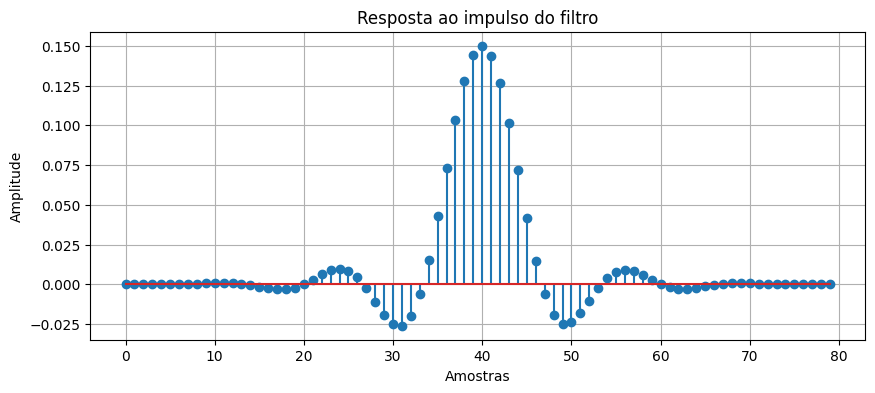

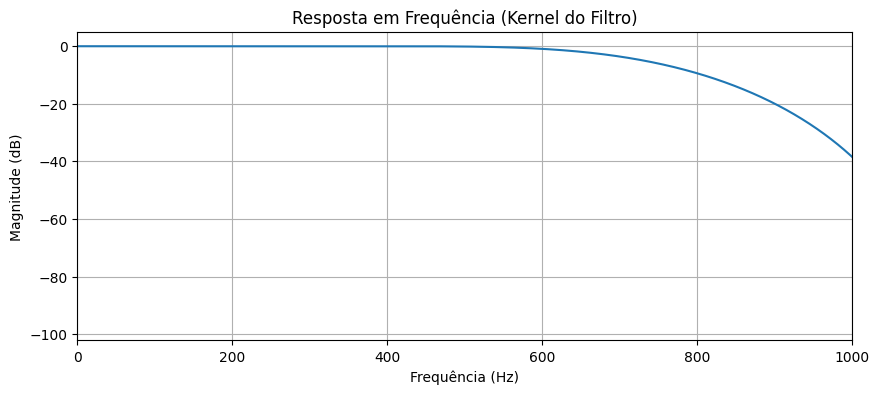

In [109]:
BW_PB = 500
Fc_PB = 750
kernel_PB = get_kernel(BW_PB, Fc_PB)

plt.figure(figsize=(10, 4))
plt.title("Resposta ao impulso do filtro")
plt.stem(np.arange(len(kernel_PB)), kernel_PB)
plt.grid()
plt.xlabel("Amostras")
plt.ylabel("Amplitude")


plt.figure(figsize=(10, 4))
w, H = signal.freqz(kernel_PB, worN=8000, fs=10000)
plt.plot(w, 20 * np.log10(abs(H)))  # Magnitude em dB
plt.title("Resposta em Frequência (Kernel do Filtro)")
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequência (Hz)")
plt.grid()
plt.xlim(0, 1000)

C:\Users\felip\AppData\Local\Temp\ipykernel_3996\3302481282.py:8: RuntimeWarning: invalid value encountered in divide
  h = np.sin(2* np.pi * Fc_norm * (n - M / 2))/(n - M/2)  # Função Sinc
C:\Users\felip\AppData\Local\Temp\ipykernel_3996\449727227.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(H)))  # Magnitude em dB


(0.0, 2000.0)

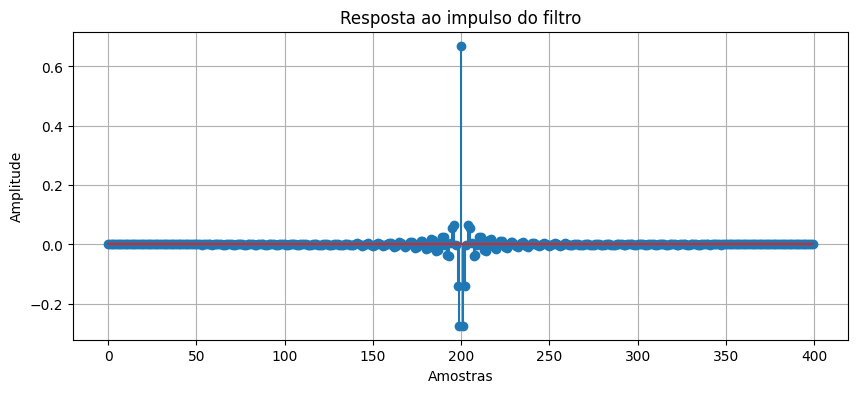

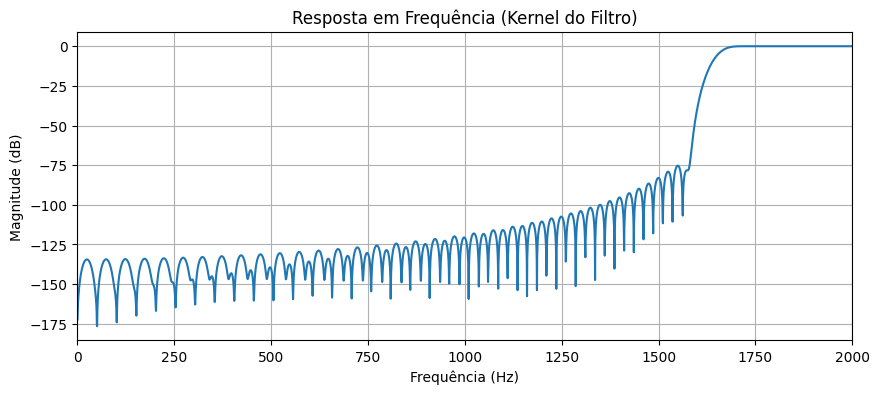

In [111]:
BW_PA = 100
Fc_PA = 1650

kernel_PA = get_kernel(BW_PA, Fc_PA)

kernel_PA = inversao_espectral(kernel_PA)

plt.figure(figsize=(10, 4))
plt.title("Resposta ao impulso do filtro")
plt.stem(np.arange(len(kernel_PA)), kernel_PA)
plt.grid()
plt.xlabel("Amostras")
plt.ylabel("Amplitude")


plt.figure(figsize=(10, 4))
w, H = signal.freqz(kernel_PA, worN=8000, fs=10000)
plt.plot(w, 20 * np.log10(abs(H)))  # Magnitude em dB
plt.title("Resposta em Frequência (Kernel do Filtro)")
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequência (Hz)")
plt.grid()
plt.xlim(0, 2000)

(0.0, 2000.0)

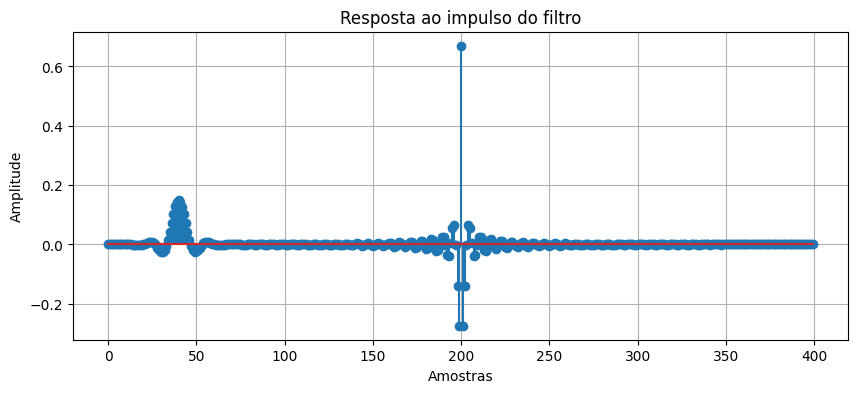

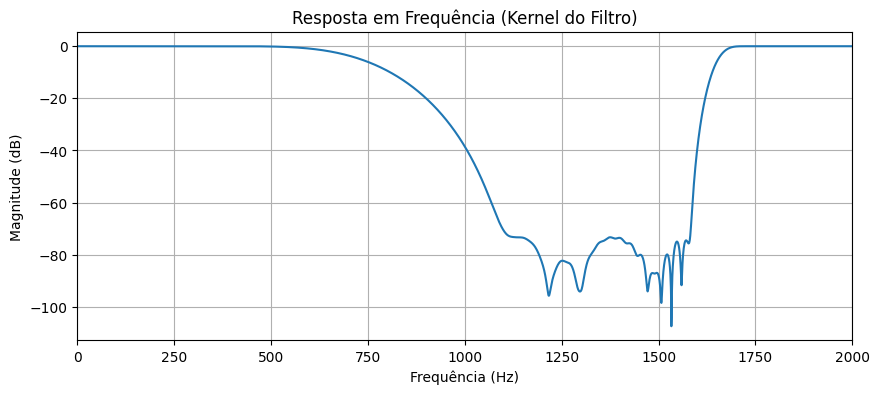

In [113]:
len_PB = len(kernel_PB)
len_PA = len(kernel_PA)

if len_PB > len_PA:
    kernel_PA = np.pad(kernel_PA, (0, len_PB - len_PA), 'constant')
elif len_PA > len_PB:
    kernel_PB = np.pad(kernel_PB, (0, len_PA - len_PB), 'constant')

kernel_RF = np.sum([kernel_PB, kernel_PA], axis=0)

plt.figure(figsize=(10, 4))
plt.title("Resposta ao impulso do filtro")
plt.stem(np.arange(len(kernel_RF)), kernel_RF)
plt.grid()
plt.xlabel("Amostras")
plt.ylabel("Amplitude")


plt.figure(figsize=(10, 4))
w, H = signal.freqz(kernel_RF, worN=8000, fs=10000)
plt.plot(w, 20 * np.log10(abs(H)))  # Magnitude em dB
plt.title("Resposta em Frequência (Kernel do Filtro)")
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequência (Hz)")
plt.grid()
plt.xlim(0, 2000)

### 2) Executar a filtragem do sinal. Forneça:

In [114]:
def cortar_transitorio(sinal,filtrado):
    dif = len(filtrado) - len(sinal)
    if dif % 2 == 0:
        return filtrado[int(dif/2):len(filtrado)-int(dif/2)]
    else:
        return filtrado[int(dif/2):len(filtrado)-int(dif/2)-1]

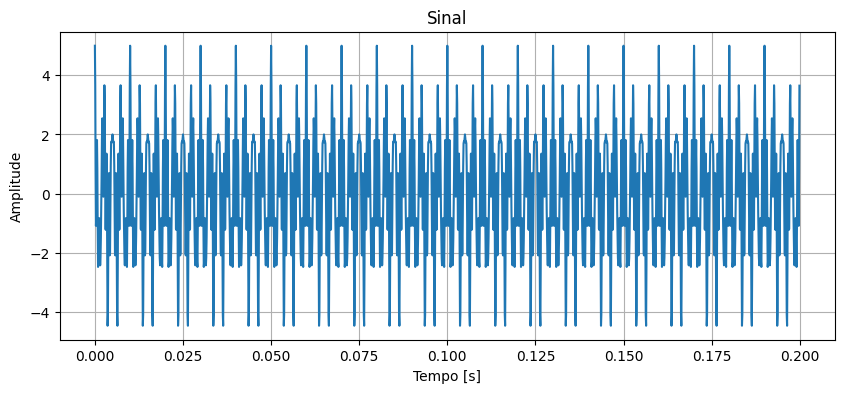

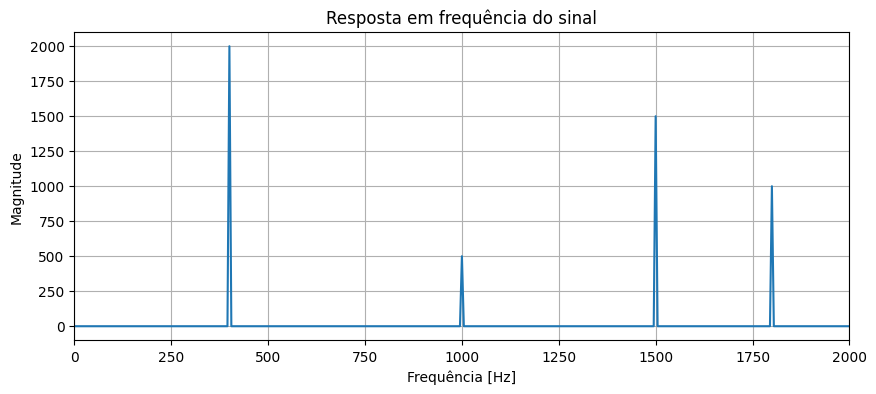

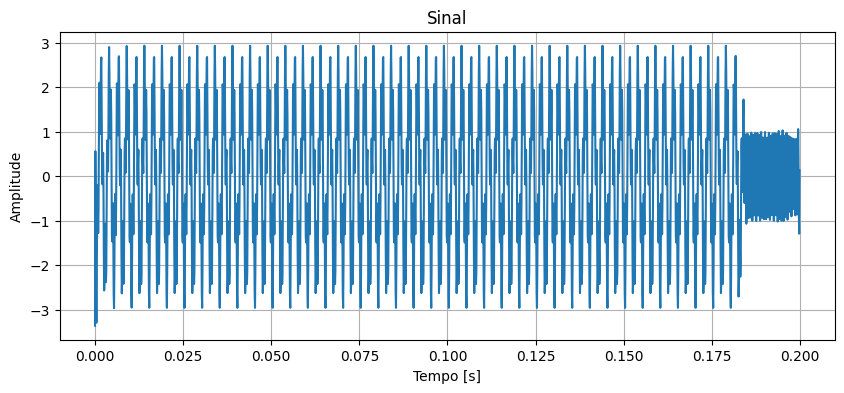

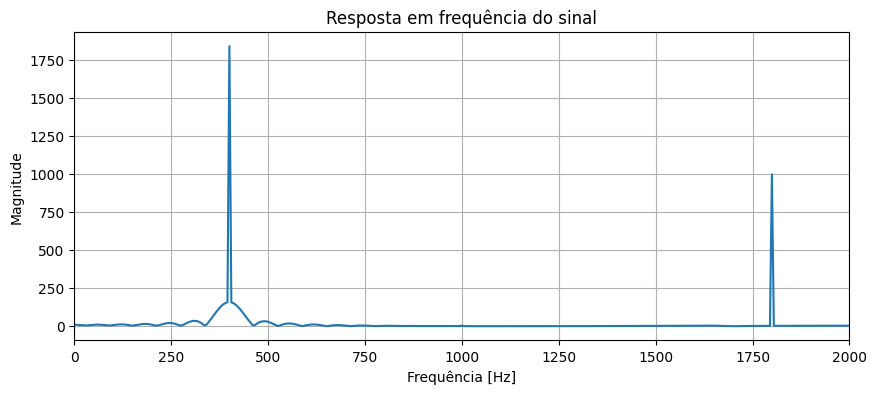

In [116]:
sinal_filtrado = np.convolve(s, kernel_RF)

sinal_filtrado_ = cortar_transitorio(s, sinal_filtrado)
plot_signal(s, t, 1/Ts, limite=2000)
plot_signal(sinal_filtrado_, t, 1/Ts, limite=2000)